In [2]:
import argparse
import os
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torch.nn.utils.spectral_norm as spectralnorm
import torchvision
import matplotlib.pyplot as plt

from models import *
from utils import *
from helper import *

!nvidia-smi

Tue Feb 27 13:53:59 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:06:00.0 Off |                    0 |
| N/A   38C    P8    16W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [37]:
def plot_img_series(x_1,x_2,x_1_hat,x_2_hat_joint, x_2_hat_new):
    fig, axarr = plt.subplots(3,2)
    fig.set_size_inches(10, 15)

    axarr[0,1].axis('off')
    axarr[0,0].axis('off')
    axarr[1,0].axis('off')
    axarr[1,1].axis('off')
    axarr[2,0].axis('off')
    axarr[2,1].axis('off')

    axarr[0,0].set_title(r"$X_1$")
    axarr[0,1].set_title(r"$X_1$")
    axarr[1,0].set_title(r"$\hat{X}_1$")
    axarr[1,1].set_title(r"$\hat{X}_2 ~ PLF-JOINT$")
    axarr[2,0].set_title(r"$\hat{X}_1$")
    axarr[2,1].set_title(r"$\hat{X}_2 ~ PLF-NEW$")

    axarr[0,0].imshow(x_1.cpu().data.numpy(),cmap = 'gray')
    axarr[0,1].imshow(x_2.cpu().data.numpy(),cmap = 'gray')
    axarr[1,0].imshow(x_1_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,1].imshow(x_2_hat_joint.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,0].imshow(x_1_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,1].imshow(x_2_hat_joint.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[2,0].imshow(x_1_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[2,1].imshow(x_2_hat_new.squeeze().cpu().data.numpy(),cmap = 'gray')

In [38]:
def compare_models(z_dim = 12 ,lambda_MSE = 1.0, lambda_PN = 0.0 ,lambda_P = 0.0):
    # path to load trained models from
    pre_path_PN = f'./saved_models/R1-eps|_dim_128|z_dim_{z_dim}|L_2|lambda_gp_10|bs_64|dpenalty_0.0|'\
                + f'lambdaP_0.0|lambdaPN_{lambda_PN*1e-3}|lambdaMSE_{lambda_MSE}'

    pre_path_P = f'./saved_models/R1-eps|_dim_128|z_dim_{z_dim}|L_2|lambda_gp_10|bs_64|dpenalty_0.0' \
                + f'|lambdaP_{lambda_P*1e-3}|lambdaPM_0.0|lambdaMSE_1.0'


    # load MMNIST
    train_loader, test_loader = get_dataloader(data_root='./data/', seq_len=8, batch_size=64, num_digits=1)

    # load fixed encoder for first frame
    device = torch.device('cuda' if torch.cuda.is_available else cpu)
    I_dim = 12 
    I_L = 2
    encoder = Encoder(dim=I_dim, nc=1, stochastic=True, quantize_latents=True, L=I_L).to(device).eval() 
    decoder = Decoder_Iframe(dim=I_dim).to(device).eval()
    decoder_hat = Decoder_Iframe(dim=I_dim).to(device).eval()
    encoder.load_state_dict(torch.load('./I3/I_frame_encoder_zdim_12_L_2.pth'))
    decoder.load_state_dict(torch.load('./I3/I_frame_decoderMMSE_zdim_12_L_2.pth'))
    decoder_hat.load_state_dict(torch.load('./I3/I_frame_decoder_zdim_12_L_2.pth'))

    #load ssf modelS for second frame

    # new metric
    ssf_PN = ScaleSpaceFlow_R1eps(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_PN.motion_encoder.load_state_dict(torch.load(pre_path_PN+'/m_enc.pth'))
    ssf_PN.motion_decoder.load_state_dict(torch.load(pre_path_PN+'/m_dec.pth'))
    ssf_PN.P_encoder.load_state_dict(torch.load(pre_path_PN+'/p_enc.pth'))
    ssf_PN.res_encoder.load_state_dict(torch.load(pre_path_PN+'/r_enc.pth'))
    ssf_PN.res_decoder.load_state_dict(torch.load(pre_path_PN+'/r_dec.pth'))

    # joint metric
    ssf_P = ScaleSpaceFlow_R1eps(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_P.motion_encoder.load_state_dict(torch.load(pre_path_P+'/m_enc.pth'))
    ssf_P.motion_decoder.load_state_dict(torch.load(pre_path_P+'/m_dec.pth'))
    ssf_P.P_encoder.load_state_dict(torch.load(pre_path_P+'/p_enc.pth'))
    ssf_P.res_encoder.load_state_dict(torch.load(pre_path_P+'/r_enc.pth'))
    ssf_P.res_decoder.load_state_dict(torch.load(pre_path_P+'/r_dec.pth'))


    batch_index = torch.randint(64,(1,)).item()

    x = next(iter(test_loader))
    x = x.permute(0, 4, 1, 2, 3).to(device).float()

    # original frames
    x_1 = x[batch_index,0,0,:,:]
    x_2 = x[batch_index,0,1,:,:]

    hx = encoder(x[:,:,0,...])[0]
    x_ref = decoder(hx)
    x_1_hat = decoder_hat(hx).detach()
    x_2_hat_joint = ssf_P(x[:,:,1,...], x_ref, x_1_hat)
    x_2_hat_new = ssf_PN(x[:,:,1,...], x_ref, x_1_hat)

    plot_img_series(x_1, x_2,
                    x_1_hat[batch_index,0:,:], 
                    x_2_hat_joint[batch_index,0:,:], 
                    x_2_hat_new[batch_index,0:,:])








Finished Loading MNIST!
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]


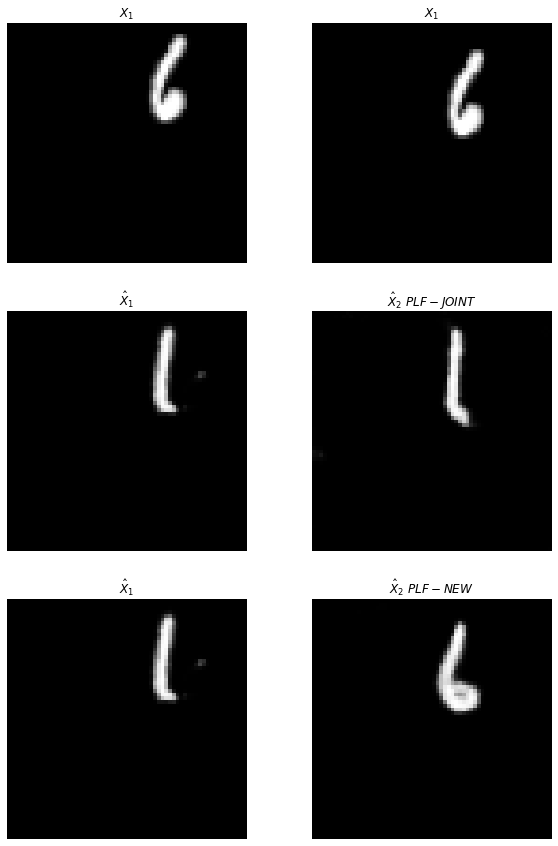

In [39]:
compare_models(z_dim = 4,lambda_MSE = 1.0, lambda_PN = 80 ,lambda_P = 80)